# Homework 6: Reinforcement Learning

## Task 1 (50 points): Formulating Real World Problems as MDPs

#### Prompt
We discussed how we can formulate RL problems as an MDP. Describe any
real-world application that can be formulated as an MDP. Describe the state space, action
space, transition model, and rewards for that problem. You do not need to be precise in the
description of the transition model and reward (no formula is needed). Qualitative description
is enough.

#### Response

Almost any real life problem can be formulated as an MDP, however often in real life the state space or action space is gigantic to the point its computationally infeasible to actually model most problems as an MDP. Hence the best we can do is map very complex tasks to much simpler MDPs that hide underlying complexity of real life. To demonstrate this I have selected a culinary robot making a salad as a real life task that could be modeled using MDPs. The state encompasses the states of all the ingredient and the state of the salad bowl, what order items have been placed inside of it. The action space consits of transforming individual ingredients via cutting, dicing, blending, or crushing, and placing them into the bowl. Once in the bowl, another action could be mixing and tossing. The transition model for the agent takes an action on an ingredient and performs it, modifying the kitchen state. For example, The action "blend tomato" takes the tomato, places it in a blender, blends it and places the blended tomato sauce in a cup, bringing us to a state where the tomato is now a blended tomato but the rest of the kitchen is the same. Other actions like "Move ingredient to bowl" can only be performed once per ingredient and result in a new state where that ingredient is in the bowl at the layer it was placed in. The rewards for the agent are delivered once a terminal state is reached, terminal states are reached once all the ingredients have been placed in the bowl and the agent is done mixing and tossing. If we're willing to wait the reward can be given based on how highly a custom has rated their meal, however this is unrealistic in real life, a better reward would be how closely the salad matches pre-determined salads on the menu. 

## Task 2 (50 points): Reinforcement Learning in concrete domains

#### Prompt
RL is used in various sectors - Healthcare, recommender systems and trading
are a few of those. Pick one of the three areas. Explain one of the problems in any of these
domains that can be more effectively solved by reinforcement learning. Find an open-source
project (if any) that has addressed this problem. Explain this project in detail.

#### Response

Healthcare is a key area where advances in RL make real impacts and saving lives. A key challenge in healthcare is Anatomical Landmark Detection. Anatomical Landmarks are biologically meaningful locations within an organism that can be used to help identify common structures despite differences between individual members of the species. This task is particularly relevant in terms of medical imaging where images can consist of 3d scans of the brain such as MRIs where we're looking at images of single slices, as well as ultrasounds. In the brain some landmarks are the sulci and gyri we expect to find in all human brains but may come in different shapes and sizes varying by individual due to age, sex, and diseases. Anatomical Landmark Detection is an incredibly important task as anatomical landmark detection is the basis for identifying the position of things within the brain such as tumors and can serve as a first step towards identifying diseases based on relative positioning and structure. 

An open-source project that addresses this issue is RL-Medical which can be found on github at https://github.com/gml16/rl-medical. Additionally, this project is outlined in the 2020 paper "Communicative Reinforcement Learning Agents for Landmark Detection in Brain Images" published at MICCAI 2020. This project uses RL, specifically DQNs and multi-agent reinforcement learning to to get state-of-the-art results on anatomical landmark detection tasks in the brain. The core idea is that landmark's position in the brain are typically correlated with each other in 3d space. The agents communicate durning training to help each other find the landmark they are looking for. States are defined as the 45 x 45 x 45 voxel region that surround and agent, essentially the 3d brain scan is transformed into voxel rather than pixels. The action space is defined as what direction the agent will move within the 3d voxel world, meaning there are 6 possible states. The step size is computed based on how close the agent is to a target point and the episode ends when all agents are oscillating around a target. Rewards are based on the euclidean distance between the current target point and the true landmark and clipped between 1 and -1. Aditionally the agents themselves are able to share information in their fully connected layers. The architecture itself is called C-MARL and uses a 3d convolutional neural network with alternating pooling and convolutional layers before a fully connected layer which averages outputs of each layer with average outputs of other agents layers, leading to a form of multi-agent communication. The agent was able to get impressive results beating out Collab-DQN (a general purpose DQN RL multi agent model) on many of their brain landmark detection benchmarks.

## Task 3 (100 points): Implementation of Q-Learning for Tik Tak Toe.

#### Prompt
Implement the game of tic-tac-toe (write a class that implements an agent
playing Tic Tac Toe and learning its Q function) using the Q-learning technique (see the
resources/links provided in class for more details). Clearly describe your evaluation metric and
demonstrate a few runs. You might need to use some online resources to proceed on this. Do
not forget to cite those.

#### Response
One of the main resources I used was [this article](https://towardsdatascience.com/reinforcement-learning-q-learning-with-illegal-actions-from-scratch-19759146c8bf), which describes how you should do Q-learning when your available actions are limited on a state by state basis. I.E., in tic-tak-toe, you are not allowed to put a mark on top of another mark. Additionally I made use of [this article](https://towardsdatascience.com/an-ai-agent-learns-to-play-tic-tac-toe-part-3-training-a-q-learning-rl-agent-2871cef2faf0) which helped me reason throw how to implement exploration vs exploitation during training. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:


actionNames = {
    0: "(0, 0) Upper Left",
    1: "(1, 0) Upper Center",
    2: "(2, 0) Upper Right",
    3: "(0, 1) Middle Left",
    4: "(1, 1) Middle Center",
    5: "(2, 1) Middle Right",
    6: "(0, 2) Lower Left",
    7: "(1, 2) Lower Center",
    8: "(2, 2) Lower Right",
}

actions = actionNames.keys()

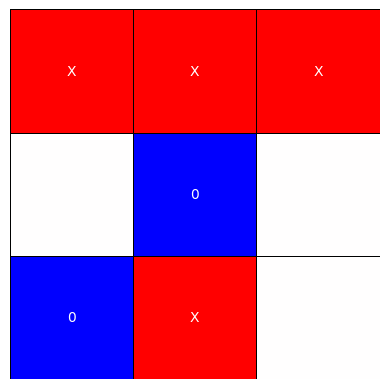

In [226]:
#Board drawing utility
def drawBoard(board, saveName=None):
    labelMap = np.vectorize(lambda value: {1:"X", -1:"0", 0:" "}[value])
    shapedBoard = np.reshape(board, (3, 3))
    labels = labelMap(shapedBoard)
    sns.heatmap(shapedBoard, cmap="bwr", annot=labels, 
        linewidth=.5, linecolor="black", fmt="", cbar=False,
        square=True, xticklabels=False, yticklabels=False, vmin=-1, vmax=1)
    if saveName:
        plt.savefig(f"figs/{saveName}")

#Testing
drawBoard([1, 1, 1, 0, -1, 0, -1, 1, 0])

In [5]:
#Instead of a tik tak toe class, we pre-generate the whole game tree to speed up checking the winner since ticktacktoe is a reasonably small game

#Maps board arrays to states to save us space, we reuse state nodes if we encounter a state that already exists
boardToState = {}

class GameStateNode():
    def __init__(self):
        #if we are a termination state (leaf node), self.winner is who won, X or O, else is None if draw or not leaf node
        self.winner = 0  
        
        #an dict representing the map between actions the child states
        self.children = {}
        
        #The board representation as an array of 9 positions, we can use this for drawing any state
        #0 represents an empty box, 1 represents a X, -1 represents a 0
        self.board = None


#There are only 8 win masks, faster to index all of them rather than add every time
winMasks = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0, 0], #Horizontal wins
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 1, 0, 0], #Vertical Wins
    [0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1], #Diagonal wins
    [0, 0, 1, 0, 1, 0, 1, 0, 0]
])

def win(board):
    for winMask in winMasks:
        maskedSum = np.sum(winMask*board)
        if maskedSum == 3:
            return 1
        elif maskedSum == -3:
            return -1
    return 0


def buildGameTree(node, board, player):
    node.winner = win(board)
    if node.winner:             #if the game isn't over, create new branches for all actions
        return
    for action in actions:
        if board[action] == 0:  #if move is legal
            newBoard = np.copy(board)
            newBoard[action] = player
            newBoard.flags.writeable = False
            if newBoard.tobytes() in boardToState:             #Reuse trees for states we've already seen
                newNode = boardToState[newBoard.tobytes()]     
            else:                                                   #Create new tree if we have not seen it
                newNode = GameStateNode()                    
                newNode.board = newBoard
                buildGameTree(newNode, newBoard, -player)
                boardToState[newBoard.tobytes()] = newNode
            node.children[action] = newNode

In [6]:
root = GameStateNode()
emptyBoard = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
boardToState[emptyBoard.tobytes()] = root
root.board = emptyBoard
buildGameTree(root, emptyBoard, 1)

#We expect for tic-tac-toe to get 5478 valid states according to
#https://stackoverflow.com/a/25358690/6342516
len(boardToState)

5478

In [7]:
#Visualizing my game tree
import networkx as nx

gameGraph = nx.DiGraph()
for boardBytes, node in boardToState.items():
    gameGraph.add_node(boardBytes, children=len(node.children), state=str(node.board), depth=np.count_nonzero(node.board), winner=node.winner)
for boardBytes, node in boardToState.items():
    for _, child in node.children.items():
        gameGraph.add_edge(boardBytes, child.board.tobytes())

nx.write_gexf(gameGraph, "TicTacToe.gexf")

I export the game state tree into Gephi where I visualize it using a radial axis layout, with each spoke being the move the state can occur on. The visualization offers several interesting insights compiled into the following image I've created. The first insight is that there are no games that end until the 5th move, which is expected since the 2nd player must make at least 2 plays and first player must make 3 to get 3 in a row. We can see that the majority of win occur for the first player around turn 7.

![Image](Analysis.jpg)

We now begin implementing our agent. 

In [20]:

#Setup our Q-table

#Map board states to Q-Table indices
boardToQIndex = {b:i for i, (b, _) in enumerate(boardToState.items())}
qTable = None

def initQTable():
    global qTable
    #create Q-Table full of NaNs with shape numStates x numActions
    qTable = np.full((len(boardToQIndex), len(actions)), np.nan)

    #fill legal Q-table actions with 0s
    for board, state in boardToState.items():
        for action, _ in state.children.items():
            qTable[boardToQIndex[board], action] = 0

initQTable()
print(qTable[-10:, :])



[[ 0.  0.  0.  0.  0.  0.  0. nan  0.]
 [nan  0.  0.  0.  0.  0.  0.  0. nan]
 [ 0. nan  0.  0.  0.  0.  0.  0. nan]
 [ 0.  0. nan  0.  0.  0.  0.  0. nan]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan]
 [ 0.  0.  0.  0. nan  0.  0.  0. nan]
 [ 0.  0.  0.  0.  0. nan  0.  0. nan]
 [ 0.  0.  0.  0.  0.  0. nan  0. nan]
 [ 0.  0.  0.  0.  0.  0.  0. nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan]]


We now write the training and testing loop. For each episode we alternate between playing Xs and Os (going first or second), we play against an agent who will select a random legal move to ensure that we have relatively full coverage of our state space. During training we use a hyperparameter epsilon to determine the chance that we try a random move rather than what we currently perceive to be our best move. We only reward at the end states, +1 for win -1 for loss and 0.1 for a draw.

In [222]:

#Hyperparameters:
learningRate = 0.1
discountFactor = 0.9
epsilon = 0.2           #Probability of picking a random action rather than best action

#Run the agent for a number of episodes, if training == True, will use epsilon to determine exploration vs exploitation. 
#If getGames == True, will log the games that the agent played and return them, else 2nd return is empty array
def run(numEpisodes, training = True, saveGames = False):
    global qTable
    player = 1              #Which player is being played as
    winner = [] #List of who's won and as what player
    if training:
        initQTable()   #If we're training reset the Q-Table

    savedGames = None
    if saveGames:
        savedGames = []
    #np.random.seed(9192000)
    for episode in range(numEpisodes):
        player = -player            #swap who we're playing as each episode
        if episode % 1000 == 0:
            print(episode, end=" ")
        curState = root             #Start at the base of the tic tac toe game tree
        if saveGames:
            savedGame = [curState.board]
        if player == -1:        #if we're the second player, let the other player pick first
            curState = np.random.choice(list(curState.children.values()))
            if saveGames:
                savedGame.append(curState.board)
        
        while True: #We will break if either player reaches an end state

            #RL Agent's Turn
            #Select our action based on Exploration vs Exploitation
            if training and np.random.uniform() < epsilon: #Exploration, choose random action
                action = np.random.choice(list(curState.children.keys()))
            else:                             #Exploitation, choose based on best Q-Value
                action = np.nanargmax(qTable[boardToQIndex[curState.board.tobytes()], :])

            #Update Q-Table
            nextState = curState.children[action]
            if training:
                Qsa = qTable[boardToQIndex[curState.board.tobytes()], action]
                #We've hit a win state
                if len(nextState.children) == 0:                                    
                    reward = 0.1 if nextState.winner == 0 else nextState.winner*player
                    newQsa = Qsa + learningRate*(reward - Qsa)
                    qTable[boardToQIndex[curState.board.tobytes()], action] = newQsa #Update our Q-table 
                    winner.append(("RL", player, 0 if nextState.winner == 0 else player))
                    break
                
                #We're not hitting a win state
                else:
                    # We go through each child of the move after our next one
                    futureValues = set()
                    for _, state in nextState.children.items():
                        if len(state.children) == 0:   #The opponent has won the game, return 0
                            futureValues.add(0)
                        else:
                            futureValue = np.nanmax(qTable[boardToQIndex[state.board.tobytes()], :])
                            futureValues.add(futureValue)
                    optimalFutureValue = max(futureValues) 
                    newQsa = Qsa + learningRate*(discountFactor*optimalFutureValue - Qsa)
                    qTable[boardToQIndex[curState.board.tobytes()], action] = newQsa #Update our Q-table 
            else: #If we're testing, check if we win
                if saveGames:
                    savedGame.append(nextState.board)
                if len(nextState.children) == 0:
                    if saveGames:
                        savedGames.append(savedGame)
                    winner.append(("RL", player, 0 if nextState.winner == 0 else player))
                    break
            
            curState = nextState  #Move to the selected state

            #Random Agents turn
            curState = np.random.choice(list(curState.children.values()))
            if saveGames:
                savedGame.append(curState.board)
            if len(curState.children) == 0:
                if saveGames:
                    savedGames.append(savedGame)
                winner.append(("Rand", -player, 0 if curState.winner == 0 else -player))
                break
    print("\n")
    return winner, savedGames



In [232]:
trainingEpisodes = 250000
testingEpisodes = 5000
trainingWinners, _ = run(trainingEpisodes)
testingWinners, _ = run(testingEpisodes, False)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 

We show that the Agent's performance converges by looking at the % of games it wins within an window of time while training, we can clearly see the agent's performance converging. 

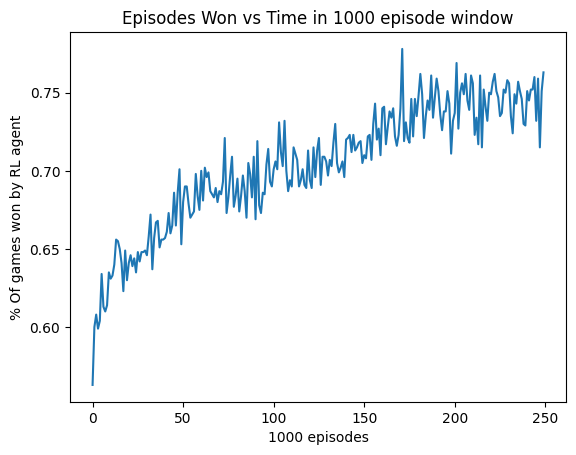

In [233]:
import matplotlib.pyplot as plt

window = 1000

average = []
for start in range(0, trainingEpisodes, window):
    count = 0
    for (name, player, winner) in trainingWinners[start:start+window]:
        if name == "RL" and winner != 0:
            count += 1
    average.append(count / window)

plt.title(f"Episodes Won vs Time in {window} episode window")
plt.xlabel(f"{window} episodes")
plt.ylabel(f"% Of games won by RL agent")
plt.plot(average)



We investigate our Q-Table after we have run all the episodes.

In [234]:
np.set_printoptions(2, suppress=True)
print("End of Q-Table")
print(qTable[-15:,:])
print("===============")
print("Start of Q-Table")
print(qTable[:15,:])

End of Q-Table
[[0.81 0.22 0.03 0.17 0.07  nan 0.01  nan  nan]
 [0.81 0.32 0.07 0.12 0.2   nan 0.13  nan 0.13]
 [0.81 0.16 0.13 0.09 0.   0.02  nan  nan  nan]
 [0.81 0.41 0.2  0.06 0.25 0.08  nan  nan 0.1 ]
 [0.81 0.22 0.25 0.23 0.11 0.18 0.04  nan  nan]
 [0.81 0.81 0.81 0.81 0.81 0.8  0.8   nan 0.81]
 [ nan 0.69 0.16 0.05 0.05 0.4  0.15 0.15  nan]
 [0.9   nan 0.19 0.12 0.26 0.29 0.16 0.14  nan]
 [0.9  0.19  nan 0.08 0.19 0.08 0.15 0.11  nan]
 [0.81 0.36 0.13  nan 0.25 0.09 0.12 0.15  nan]
 [0.81 0.29 0.08 0.06  nan 0.13 0.13 0.06  nan]
 [0.81 0.16 0.11 0.2  0.26  nan 0.16 0.09  nan]
 [0.9  0.2  0.16 0.18 0.19 0.19  nan 0.07  nan]
 [0.9  0.24 0.22 0.19 0.32 0.18 0.14  nan  nan]
 [0.81 0.81 0.81 0.81 0.81 0.73 0.81 0.79  nan]]
Start of Q-Table
[[0.81 0.81 0.81 0.81 0.81 0.73 0.81 0.8  0.81]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan 1.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan 

We end by investigating the breakdown of how many games each agent won

In [235]:
def evaluate(winners, numEpisodes):
    drawRL = winners.count(("RL", 1, 0)) + winners.count(("Rand", -1, 0))
    drawRand = winners.count(("RL", -1, 0)) + winners.count(("Rand", 1, 0))
    draws = drawRL + drawRand
    print(f"Draws: {draws} ({(draws)/numEpisodes*100:.2f}%)")
    print(f"\tRL Draws as X: {drawRL} ({(drawRL)/numEpisodes*100:.2f}%)")
    print(f"\tRL Draws as O: {drawRand} ({(drawRand)/numEpisodes*100:.2f}%)")
    rlx = winners.count(("RL", 1, 1))
    rlo = winners.count(("RL", -1, -1))
    print(f"RL Wins: {rlx + rlo} ({(rlx + rlo)/numEpisodes*100:.2f}%)")
    print(f"\tRL Wins as X: {rlx} ({rlx/numEpisodes*100:.2f}%)")
    print(f"\tRL Wins as O: {rlo} ({rlo/numEpisodes*100:.2f}%)")
    rx = winners.count(("Rand", 1, 1))
    ro = winners.count(("Rand", -1, -1))
    print(f"Rand Wins: {rx + ro} ({(rx + ro)/numEpisodes*100:.2f}%)")
    print(f"\tRand Wins as X: {rx} ({rx/numEpisodes*100:.2f}%)")
    print(f"\tRand Wins as O: {ro} ({ro/numEpisodes*100:.2f}%)")

print("During Training (With 20% random actions):")
evaluate(trainingWinners, trainingEpisodes)
print("Testing (After training, Always selecting best action):")
evaluate(testingWinners, testingEpisodes)

During Training (With 20% random actions):
Draws: 10990 (4.40%)
	RL Draws as X: 6257 (2.50%)
	RL Draws as O: 4733 (1.89%)
RL Wins: 175937 (70.37%)
	RL Wins as X: 103672 (41.47%)
	RL Wins as O: 72265 (28.91%)
Rand Wins: 63073 (25.23%)
	Rand Wins as X: 48002 (19.20%)
	Rand Wins as O: 15071 (6.03%)
Testing (After training, Always selecting best action):
Draws: 57 (1.14%)
	RL Draws as X: 23 (0.46%)
	RL Draws as O: 34 (0.68%)
RL Wins: 4367 (87.34%)
	RL Wins as X: 2420 (48.40%)
	RL Wins as O: 1947 (38.94%)
Rand Wins: 576 (11.52%)
	Rand Wins as X: 519 (10.38%)
	Rand Wins as O: 57 (1.14%)


Finally we visualize a few of our games and create a gif of them being played. We see the RL agent wins the majority of the time against the random agent.

0 



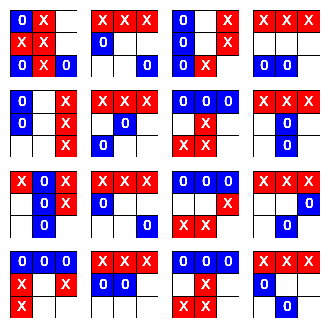

In [236]:
import imageio

_, games = run(16, False, True)

fig = plt.figure(figsize=(4, 4))
for move in range(10):
    for i in range(len(games)):
        plt.subplot(4, 4, i + 1)
        moveToShow = len(games[i]) - 1 if move >= len(games[i]) else move
        drawBoard(games[i][moveToShow])
    plt.axis('off')
    plt.savefig('figs/image_at_move_{:04d}.png'.format(move))



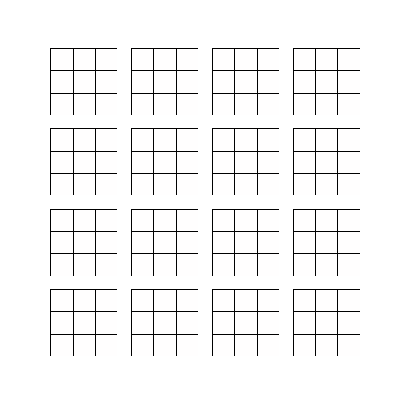

In [237]:
import glob

anim_file = 'tictactoe.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('figs/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        writer.append_data(image)
        writer.append_data(image)
        writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)